In [1]:
# Иногда картинка кривая и тд. Нужно играться с параметрами.
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import tools as tl
import genSymbolImg as gsi
import random
print(sys.version)
print(np.__version__)
print(cv2.__version__)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
1.19.2
4.0.1


In [2]:
def getGradient(gray, x = 0, y = 0, useGradient = True):
    if useGradient:
        grad = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=x, dy=y, ksize=3)
        grad = np.absolute(grad)
        (minVal, maxVal) = (np.min(grad), np.max(grad)) 
        if maxVal - minVal > 0:
            grad = (255 * ((grad - minVal) / float(maxVal - minVal))).astype("uint8")
        else:
            grad  = np.zeros(gray.shape, dtype = "uint8")
    else:
        grad = cv2.adaptiveThreshold(  gray,
                                        255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV,
                                        11,
                                        2)

    return grad

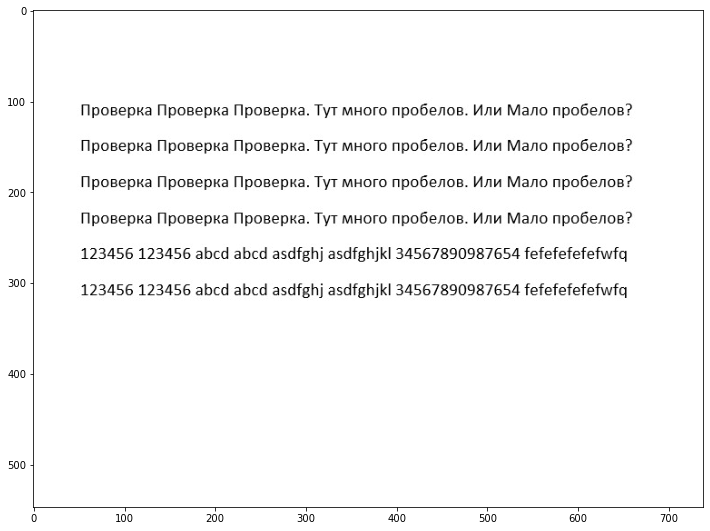

In [3]:
#Data for first task
img = cv2.imread('data/1img1.jpg', 0) # 1img(1-5)
vis = cv2.imread('data/1img1.jpg')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img, cmap='gray')
plt.show()

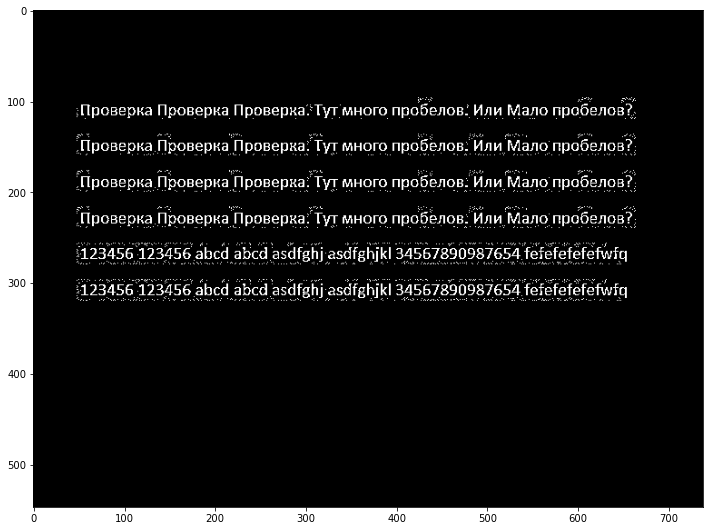

In [4]:
bin_img = getGradient(img, x = 1, useGradient = False) # True if first task
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(bin_img, cmap='gray')
plt.show()

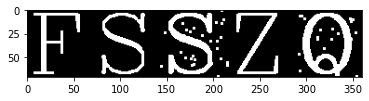

In [788]:
#FOR 2-nd task
kernel = np.ones((3,3), dtype = np.uint8)
open = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)
bin_img = open.copy()
plt.imshow(bin_img, cmap='gray')
plt.show()


In [5]:
verp = np.sum(bin_img, axis=1) / 255
drawedverp = tl.getDrawProjectionVer(img, verp)

In [6]:
half = int(np.max(verp) / 2)
sliceLine = drawedverp[:,(half-1):(half+1)]
contours, hierarchy = cv2.findContours(cv2.cvtColor(   sliceLine, 
                                                       cv2.COLOR_BGR2GRAY), 
                                                       cv2.RETR_EXTERNAL, 
                                                       cv2.CHAIN_APPROX_SIMPLE)

148


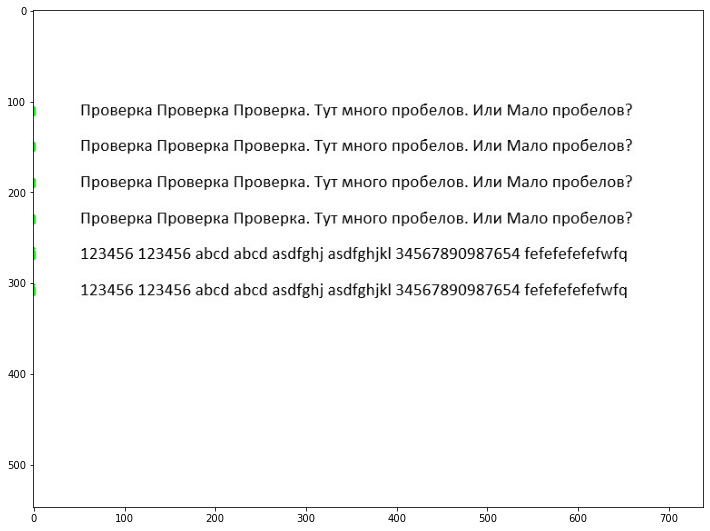

In [7]:
print(half)
img_cnts = cv2.drawContours(vis, contours, -1, (0,255,0), 2)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img_cnts, cmap='gray')
plt.show()

In [8]:
heights = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    heights.append(h)

In [9]:
medianHeight = int(np.median(np.asarray(heights)) * 1.5)
print("medianHeight", medianHeight)

medianHeight 13


In [10]:
drawedverp = cv2.line(drawedverp, 
                      (half,0), 
                      (half,drawedverp.shape[0]), 
                      (0,0,255), 
                      1)

In [11]:
kernel = medianHeight
verpConvolved = np.convolve(verp, np.ones((kernel,))/kernel, mode='same')
drawedverpconv = tl.getDrawProjectionVer(img, verpConvolved)

In [12]:
bandP1ranges = []
peaks = []
c1 = 0.2
c2 = 0.4
while np.max(verpConvolved) > 40:
    ybm = np.argmax(verpConvolved)

    yb0 = tl.findb0(verpConvolved, 
                    ybm, 
                    c1 * verpConvolved[ybm])
    yb1 = tl.findb1(verpConvolved, 
                    ybm, 
                    c2 * verpConvolved[ybm])

    if yb1 - yb0 > medianHeight:
        bandP1ranges.append((yb0,yb1))
        peaks.append((int(verpConvolved[ybm]), ybm))

    verpConvolved[yb0:yb1] = 0

In [13]:
# draw peaks
for peak in peaks:
    cv2.circle(drawedverpconv, peak, 5, (255,0,0), -1)

In [14]:
# draw bands
bandsImg = np.zeros(vis.shape, dtype = np.uint8)
for band in bandP1ranges:
    yt, yb = band
    bandsImg[yt:yb] = [0,200,0]

In [15]:
visWithBand = vis.copy()
visWithBand = cv2.addWeighted(visWithBand, 0.6, bandsImg, 0.4, 0)



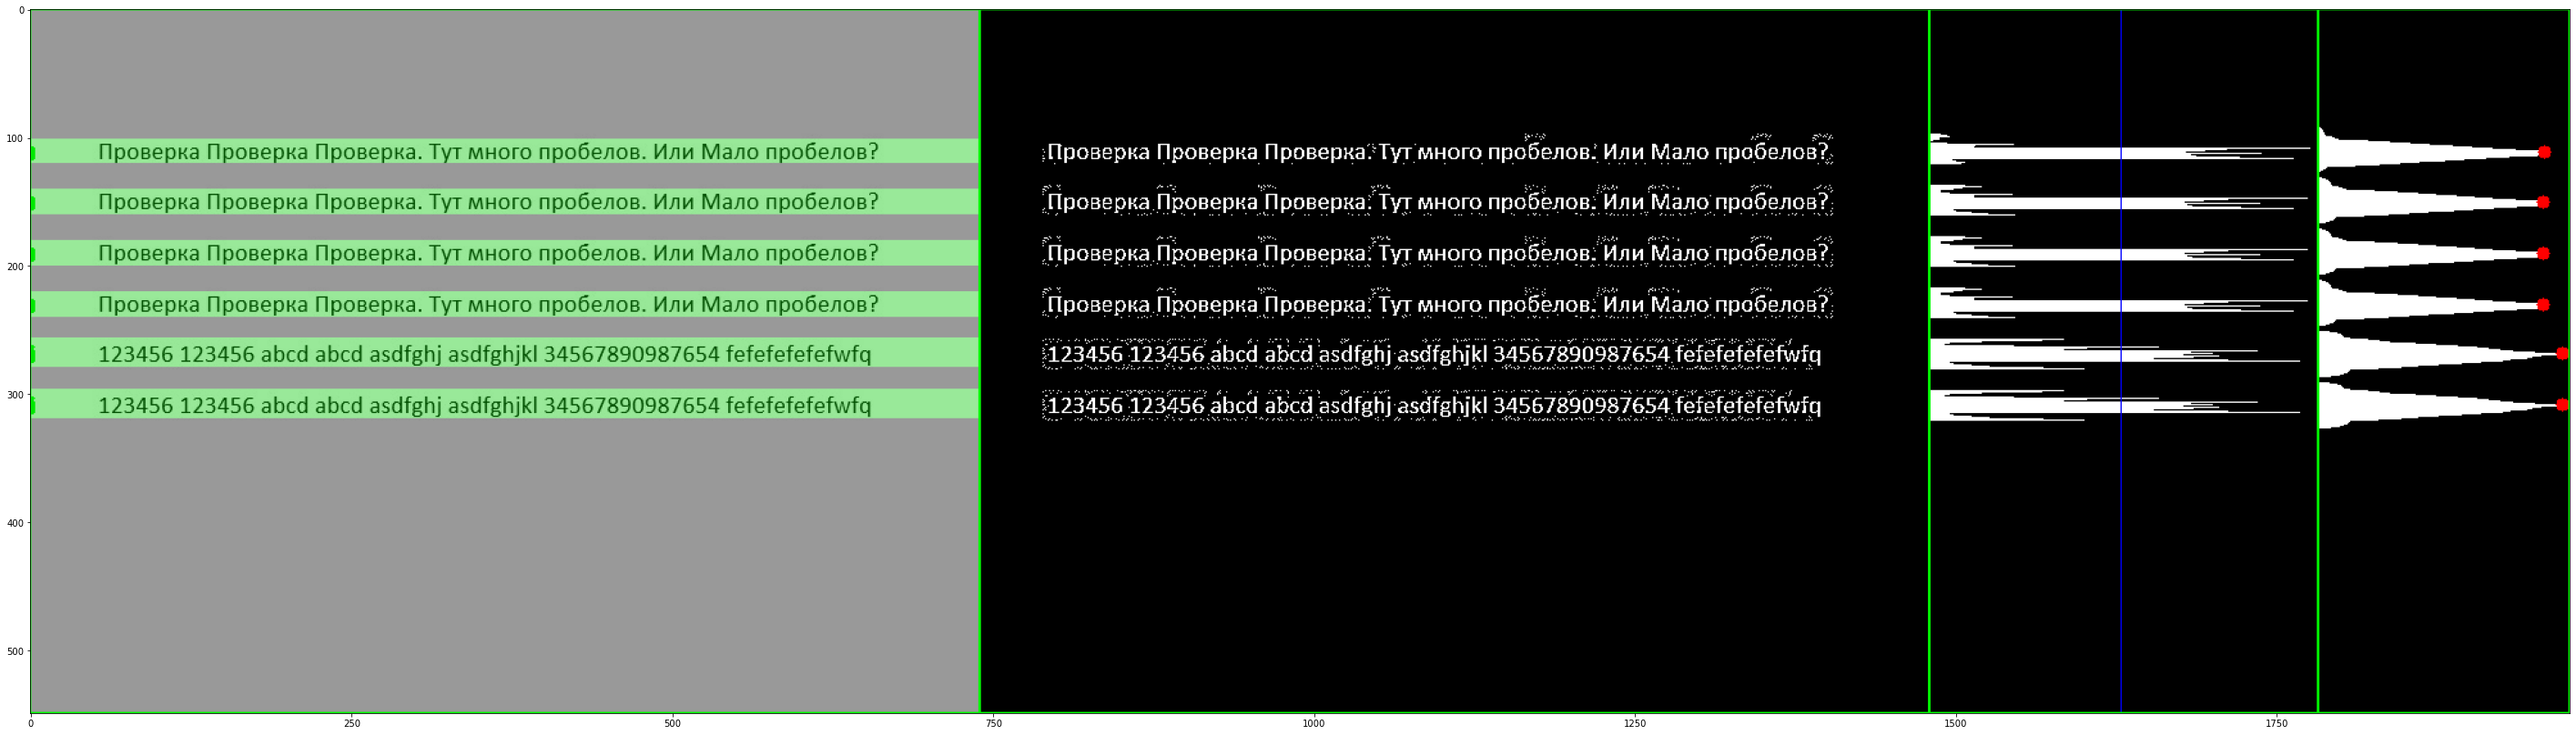

In [16]:
bigImg1 = tl.concat_hor((visWithBand,bin_img, drawedverp, drawedverpconv))
fig, ax = plt.subplots(figsize=(50, 50))
ax.imshow(bigImg1, cmap='gray')
plt.show()

In [801]:
#Cropping lines, for first tas
imgs = []
viss = []
for band in bandP1ranges:
    start, end = band
    crop_img = img[start:end]
    crop_vis = vis[start:end]
    imgs.append(crop_img)
    viss.append(crop_vis)

In [802]:
# For second task
imgs = []
viss = []
imgs.append(img)
viss.append(vis)

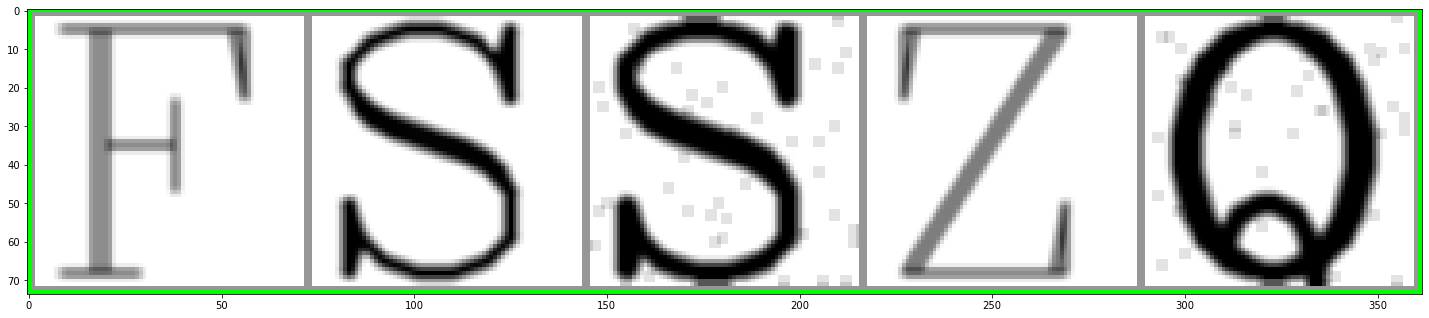

In [803]:
bigImg = tl.concat_ver((imgs))
fig, ax = plt.subplots(figsize=(25, 25))
ax.imshow(bigImg, cmap='gray')
plt.show()

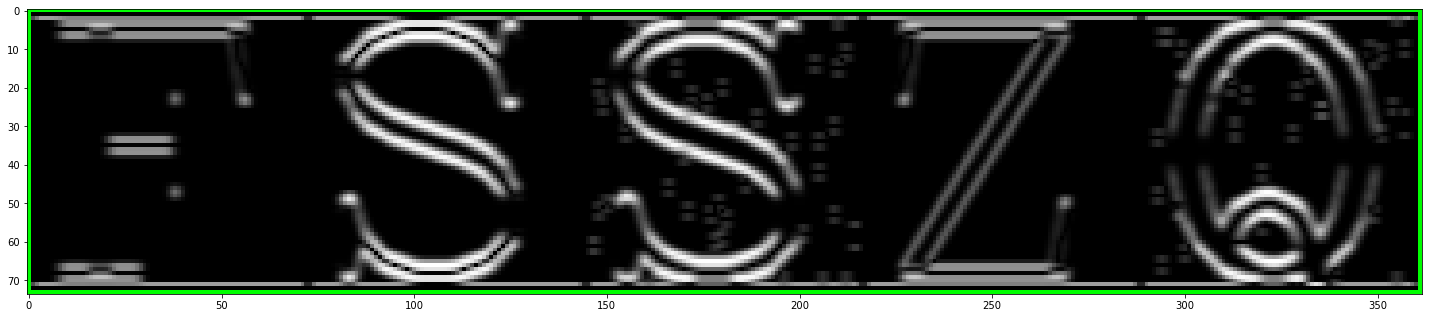

In [804]:
bin_imgs = []
for i in imgs:
    b_i = getGradient(i, y = 1, useGradient = True)
    bin_imgs.append(b_i)
bigImg = tl.concat_ver((bin_imgs))
fig, ax = plt.subplots(figsize=(25, 25))
ax.imshow(bigImg, cmap='gray')
plt.show()

In [805]:
horps = []
drawedhorps = []
for i in range(0,len(imgs)):
    horp = np.sum(bin_imgs[i], axis=0) / 255
    drawedhorp = tl.getDrawProjectionHor(imgs[i], horp)
    horps.append(horp)
    drawedhorps.append(drawedhorp)

In [806]:
halfs = []
sliceLines = []
contourss = []
for i in range(0,len(imgs)):
    half = int(np.max(horps[i]) / 2)
    sliceLine = drawedhorps[i][(drawedhorps[i].shape[0]-half-1):(drawedhorps[i].shape[0]-half+1),:]
    contours, hierarchy = cv2.findContours(cv2.cvtColor(   sliceLine, 
                                                           cv2.COLOR_BGR2GRAY), 
                                                           cv2.RETR_EXTERNAL, 
                                                           cv2.CHAIN_APPROX_SIMPLE)
    halfs.append(half)
    sliceLines.append(sliceLine)
    contourss.append(contours)

In [807]:
print(halfs)

[9]


In [808]:
widthss = []
for i in range(0,len(imgs)):
    widths = []
    for cnt in contourss[i]:
        x,y,w,h = cv2.boundingRect(cnt)
        widths.append(w)
    widthss.append(widths)

In [809]:
medianWidths = []
for i in range(0,len(imgs)):  
    medianWidth = int(np.median(np.asarray(widthss[i])) * 1.1)
    print("medianWidth", medianWidth)
    medianWidths.append(medianWidth)

medianWidth 49


In [810]:
for i in range(0,len(imgs)): 
    drawedhorps[i] =  cv2.line(drawedhorps[i], 
                      (0,drawedhorps[i].shape[0] - halfs[i]), 
                      (drawedhorps[i].shape[1],drawedhorps[i].shape[0]-halfs[i],), 
                      (255,0,0),
                      1)

In [811]:
kernels = medianWidths.copy()
horpConvolveds = []
drawedhorpconvs = []

for i in range(0,len(imgs)):
    horpConvolved = np.convolve(horps[i], np.ones((kernels[i],))/kernels[i], mode='same')
    drawedhorpconv = tl.getDrawProjectionHor(imgs[i], horpConvolved)
    horpConvolveds.append(horpConvolved)
    drawedhorpconvs.append(drawedhorpconv)

    

In [812]:
bandP1rangess = []
peakss = []

for i in range(0,len(imgs)):
    bandP1ranges = []
    peaks = []
    c1 = 0.22
    c2 = 0.22
    while np.max(horpConvolveds[i]) > 1:
        ybm = np.argmax(horpConvolveds[i])

        yb0 = tl.findb0(horpConvolveds[i], 
                        ybm, 
                        c1 * horpConvolveds[i][ybm])
        yb1 = tl.findb1(horpConvolveds[i], 
                        ybm, 
                        c2 * horpConvolveds[i][ybm])

        if yb1 - yb0 > medianWidths[i]:
            bandP1ranges.append((yb0,yb1))
            peaks.append((ybm, drawedhorpconvs[i].shape[0]- int(horpConvolveds[i][ybm])))

        horpConvolveds[i][yb0:yb1] = 0
    bandP1rangess.append(bandP1ranges)
    peakss.append(peaks)

In [813]:
# draw peaks
for i in range(0,len(imgs)):
        for peak in peakss[i]:
            cv2.circle(drawedhorpconvs[i], peak, 1, (255,0,0), -1)
            

In [814]:
# draw bands
bandsImgs = []
for i in range(0,len(imgs)):
    bandsImg = np.zeros(viss[i].shape, dtype = np.uint8)
    for band in bandP1rangess[i]:
        xt, xb = band
        bandsImg[:,xt] = [255,0,0]
        bandsImg[:,xb] = [0,0,255]
    bandsImgs.append(bandsImg)


In [815]:
for i in range(0,len(imgs)): 
    viss[i] = cv2.addWeighted(viss[i], 0.5, bandsImgs[i], 0.5, 0)

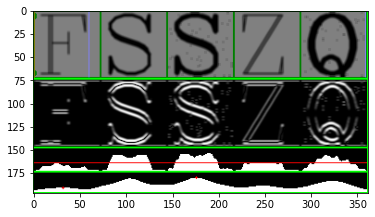

In [816]:
allImages = []
for i in range(0,len(imgs)):
    allImages.append(viss[i])
    allImages.append(bin_imgs[i])
    allImages.append(drawedhorps[i])
    allImages.append(drawedhorpconvs[i])

                     
bigImg = tl.concat_ver((allImages))
plt.imshow(bigImg, cmap='gray')
plt.show()

In [834]:
##SECOND
%reset -f
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import tools as tl
import genSymbolImg as gsi
import random
print(sys.version)
print(np.__version__)
print(cv2.__version__)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
1.19.2
4.0.1


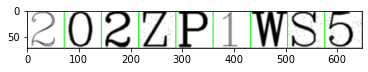

In [835]:
imgs = []
for i in range(random.randrange(5,10)):
    img, text = gsi.genSymbolImg(kw = 3, kh = 3, blur = 1,font=3)
    imgs.append(img)
    
imgg = tl.concat_hor((imgs))
plt.imshow(imgg, cmap='gray')
plt.show()

(72, 648)
(72, 648, 3)


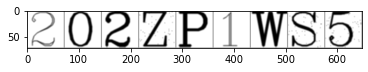

In [837]:
vis = imgg.copy()
img = cv2.cvtColor(imgg, cv2.COLOR_BGR2GRAY)
print(img.shape)
print(vis.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [828]:
# Task 2.2. Go up, and do same steps as in first task, +change some parameters like c1,c2,kernel etc...


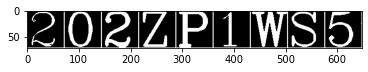

In [838]:
#Task 2.1:
ret_o, dst_o = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(dst_o, cmap='gray')
plt.show()

In [839]:
contours, hier = cv2.findContours(dst_o, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

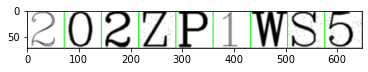

In [840]:
img_cnts = cv2.drawContours(vis, contours, -1, (0,255,0), 1)
plt.imshow(img_cnts)
plt.show()

In [ ]:
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(img_cnts, (x,y), (x+w, y+h), (255,0,0), 1)

plt.imshow(img_cnts)
plt.show()